In [1]:
import warnings
warnings.filterwarnings('ignore')

import scipy as sp
import numpy as np
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy.linalg as sla
import numpy.linalg as npla

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Лабораторная работа 2. SVD

**Внимание! Заданий много, но вам не обязательно делать все, даже чтобы получить синюю клетку**

Так что можете не делать их подряд, а сначала посмотреть все и выбрать те, которые вам больше нравятся.

## 1. Волшебные невязки (2 балла)

Сгенерируйте командой `scipy.linalg.hilbert` матрицу Гильберта размера $500\times500$. Назовём эту матрицу $A$. 

Возьмите вектор $z = (0,0,\ldots,0,1)\in\mathbb{R}^{500}$. Вычислите $b = Az$ и решите систему уравнений $Ax = b$ вашим любимым способом.

Теперь исказите вектор $b$ небольшой (по модулю не большей $0.0001$ по каждой координате) случайной ошибкой и для полученного вектора $b'$ решите систему $Ax = b'$ тем же самым способом.

Сравните невязки $||A\hat{x} - b||_2$ и $||A\hat{x}' - b'||_2$, где $\hat{x}$ и $\hat{x}'$ - полученные вами решения. Что из полученных результатов вас удивляет? Попробуйте объяснить эффект.

**Важно!** Баллы будут ставиться не за реализацию, а за объяснения!

In [2]:
n = 500
H = sla.hilbert(n)
z = np.zeros(n)
z[n - 1] = 1
z.reshape((n, 1))
b = H.dot(z) 
x = sla.solve(H, b)
sla.norm(H.dot(x) - b)

1.6286997482231658e-16

**Невязка незначительная. Посмотрим, что будет с искажённым вектором.**

In [3]:
b_eps = 1e-5 * np.random.randint(0, 10, n)
b = b + b_eps
x = sla.solve(H, b)
sla.norm(H.dot(x) - b)

0.021796873473273668

**Погрешность возросла на $~16$ порядков. Посмотрим на число обусловленнсти матрицы Гильберта и заметим, что оно очень большое:**

In [5]:
cond(H)

3.0258571184580736e+20

**Обозначим $x$ -- точное решение системы $Hx = b$, $x'$ -- точное решение системы $Hx = b'$, где $b'$ -- слегка подпорченный вектор $b$. Нам было дано следующее неравенство:**

$$
    \frac{|| x - x'||}{|| x ||} \le cond(H) \frac{||b' - b||}{|| b ||}
$$
**Из него видно, что число обусловленности показывает, во сколько раз может возрасти относительная погрешность решения по сравнению с погрешностью правой части при решении системы $Hx = b$. В нашем случае $cond(H) \sim 3.02^{20}$, поэтому**
$$
    \frac{|| x - x'||}{|| x ||} \le 3.02^{20}  \frac{||b' - b||}{|| b ||}
$$
**Видно, что даже очень маленькая погрешность правой части может привести к сильной погрешности решения - ведь чтобы скомпенсировать $20$-ю степень числа обусловленности, нужно иметь погрешность порядка $-20$, что вряд ли удастся в силу ограниченной машинной точности.**

## 2. Сжатие информации с помощью SVD (3 балла)

Загрузите выложенную на странице курса фотографию Сони Техажевой.

Поскольку фотография чёрно-белая, её можно проинтерпетировать как матрицу, элементы которой - это насыщенность серого цвета каждого из пикселей. Постройте сингулярное разложение этой матрицы (не нужно центрировать данные!). 

Визуализуйте первую главную компоненту. Ожидали ли вы увидеть именно это? Почему?

Визуализуйте компонеты с первой по двадцатую, с первой по пятидесятую, с двадцатой по сотую, с двадцатой по последнюю. Сделайте выводы.

Как вам кажется, сколько первых компонент нужно взять для достаточно хорошего восстановления исходного изображения? Во сколько раз меньше памяти потребуется для их хранения?

**Важное замечание.** Главные компоненты - это не скрытые признаки, а матрицы вида $u^{(i)}\sigma_i(v^{(i)})^T$, где $u^{(i)}, v^{(i)}$ --- столбцы матриц $U$ и $V$ соответственно. В частности, сумма первых нескольких главных компонент --- это наилучшее приближение исходной матрицы матрицей данного ранга.

### Решение

Загрузим изображение

In [4]:
from PIL import Image
from scipy import misc


img = misc.imread(r'sonyasmall.jpg', mode='L') # это матрица из интенсивностей серого цвета; её уже можно подвергать SVD

Посмотрим на Соню!

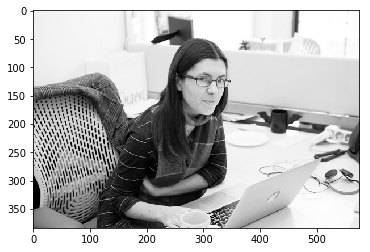

In [7]:
imgplot = plt.imshow(img, cmap='Greys_r')

**SVD-разложение для матрицы, соответствующей этому изображению.**

In [8]:
U, D, V = sla.svd(img, full_matrices = True)
print(U.shape, D.shape, V.shape)

(384, 384) (384,) (576, 576)


**Реализуем функцию, которая будет выводить нам компоненты матрицы изображения с i-ой по j-ю (не включая последнюю).**

In [9]:
def GetImageComponents(comp_i, comp_j, image):
    U, D, V = sla.svd(image, full_matrices = True)
    components = np.zeros((U.shape[0], V.shape[0]))
    for k in range(comp_i, comp_j):
        components[k][k] = D[k]
    components = U.dot(components).dot(V)
    return  components

def VizualizeComponents(comp_i, comp_j, image):
    matplotlib.rcParams['figure.figsize'] = (9, 5)
    plt.title('Components from {} to {}'.format(comp_i + 1, comp_j))
    imgplot = plt.imshow(GetImageComponents(comp_i, comp_j, image), cmap='Greys_r')
    plt.show()

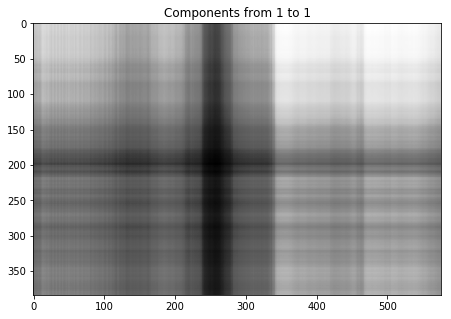

In [10]:
VizualizeComponents(0, 1, img)

**Получили размытый крест. Ничего не ясно. Но что следуюет ожидать, когда мы урезали до 1 компоненты изображение. Вполне ожидаемо.**

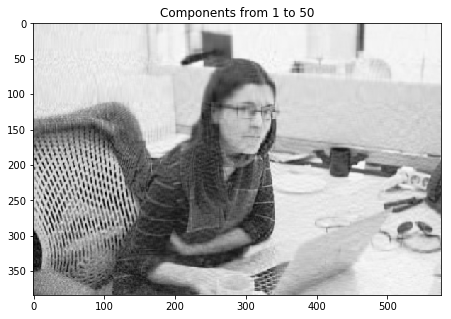

In [11]:
VizualizeComponents(0, 50, img)

**Изображение сильно размыто, но уже видны основные очертания и даже можно определить что на изображении. **

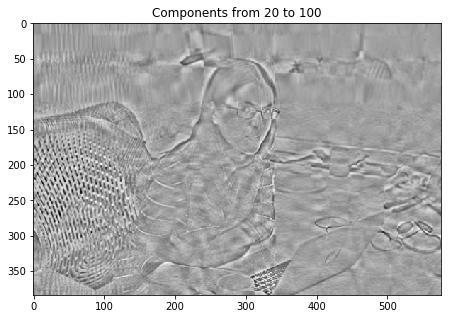

In [12]:
VizualizeComponents(19, 100, img)

**Видно, что эти последние компоненты отвечают за детализированность изображения, но без первых они могут создать лишь некоторый силуэт. Но вдруг, если взять мгного последних компонент, то изображение будет похоже на исходное? Проверим это, и выведем с 20-й по последнюю.**

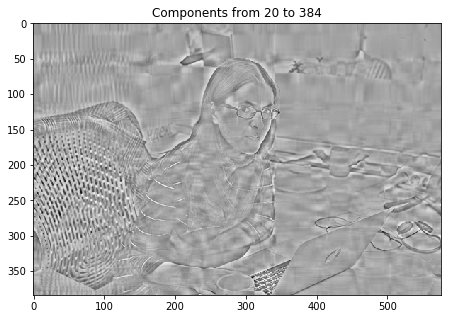

In [13]:
VizualizeComponents(19, D.shape[0], img)

**Итак, видно, что одними последними компонентами обойтись не удастся. Попробуем понять, какое количество первых компонент нужно для качетвенного сжатия. Рассмотрим компоненты с первой по сотую.**

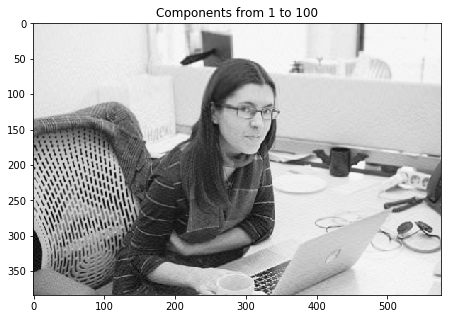

In [14]:
VizualizeComponents(0, 100, img)

**Качество не очень хорошее. Попробуем с 1 по 130ю.**

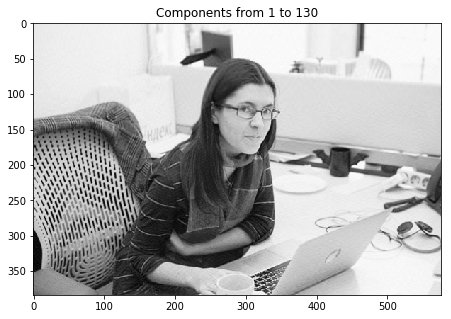

In [15]:
VizualizeComponents(0, 130, img)

**Изображение уже практически на глаз не отличается от исходного. Значит, можно, получается, хранить первые 130 компонент (то есть только первые 130 строк матрицы $U$ и первые 130 столбцов матрицы $V$). Поскольку изначально у нас было 384 компоненты, получаем, что хранение урезанного SVD занимает по памяти примерно в 3 раза меньше, чем хранение полного SVD.**

**Если же пытаться сравнивать затраты по хранению просто исходной матрицы и её урезанного SVD, то экономия тоже будет присутствовать. В исходной матрице хранится $dim(U) \cdot dim(V)$ элементов. Посчитаем, сколько элементов будет в урезанном SVD. Если мы берём $k$ всех компонент, то размеры хранимых матриц будут такими: $k \cdot dim(U)$ (это будет размер матрицы вместо $U$), $k \cdot dim(V)$ (вместо $V$), $k$ (вместо $D$). Тогда исходный размер относится к размеру урезанного $SVD$ как
$$
    \alpha = \frac{dim(U) \cdot dim(V)}{k (dim(U) + dim(U) + 1)} 
$$
Если мы храним первые 130 компонент, то для нашей матрицы этот коэффициент будет следующим:
$$
    \alpha = \frac{384 \cdot 576}{130 (384 + 576 + 1)} \simeq 1.77
$$
Экономия чуть меньше, чем в 2 раза. Если же ещё немного пренебречь качеством и хранить только первые 100 компонент, то
$$
    \alpha = \frac{384 \cdot 576}{100 (384 + 576 + 1)} \simeq 2.3
$$
Так что, в зависимости от наших целей (хотим мы иметь более высокое качество или тратить меньше памяти), можно брать большее или меньшее число компонент.**

## 3. SVD и свёртки (до 5 баллов)

В компьютерном зрении важную роль играет операция свёртки. Вообще говоря, сворачивать приходится не только матрицы, но и более сложные тензоры, однако в этом задании мы для простоты будем работать только с матрицами.

В этом задании мы будем считать, что индексы элементов в матрицах нумеруются с нуля.

Пусть $B$ --- матрица. *Свёртка* матрицы $A$ с ядром (или, как ещё говорят, с фильтром) $B$ - это матрица

$$(A * B)_{ij} = \sum_{p, q}a_{pq}b_{i - p, j - q}$$

Эту загадочную операцию можно проинтерпретировать следующим образом: для каждого элемента матрицы $A$ мы умножаем его "окрестность" (размеры этой окрестности зависят от размеров фильтра) поэлементно на соответствующие коэффициенты из ядра и всё это складываем:

<img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png">

Таким образом, каждый элемент $A$ мы как-то обновляем с учётом его соседей. Скажем, свёртка с ядром

$$B = \frac19\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}$$

будет размывать изображение.

У вас может возникнуть вопрос: а что происходит на краях? Пусть $A$ - матрица $m\times n$, а $B$ - матрица $k\times l$. Есть разные варианты, например, такие:

- можно считать, что "за пределами" $A$ и $B$ тоже есть элементы, но просто они равны нулю; тогда результат свёртки будет иметь размер $(m + k - 1)\times(n + l - 1)$;
- можно точно так же считать, что элементы, лежащие "за пределами" $A$ и $B$ равны нулю, но законными считать только те компоненты свёртки, для которых "центр" фильтра попадает в матрицу $A$, тогда результат свёртки будет иметь такой же размер, как и $A$;
- можно считать законными только те компоненты свёртки, для которых фильтр целиком помещается "внутри" $A$; в этом случае результат свёртки будет меньшего размера, чем исходная матрица, а именно $(m - k + 1)\times(n - l + 1)$.

Дальше мы будем по умолчанию считать, что границы обрабатываются первым из указанных способов.

Свёртка называется *сепарабельной*, если она представляется в виде композиции свёрток

$$A * B = (A * U) * V,$$

где $U$ и $V$ - матрицы $(2t+1)\times1$ и $1\times(2s+1)$ (или $1\times(2s+1)$ и $(2t+1)\times1$).

**Собственно задание:**

0) Сверните фотографию Сони с фильтром

$$B = \begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{pmatrix}$$

Границы можете обработать любым приятным вам способом. Как вам кажется, каков физический смысл этой операции?

1) Проверьте, что операция свёртки (в которой границы обрабатываются первым из указанных способов!) ассоциативна, то есть $(A * B) * C = A * (B * C)$;

2) Убедитесь, что сепарабельную свёртку можно посчитать быстрее, чем не сепарабельную;

3) Допустим, что вам нужно реализовать операцию свёртки с фильтром $B$, однако приоритетом для вас является скорее скорость, а не абсолютная точность, и поэтому вы готовы ценой не очень большой ошибки заменить исходную свёртку на какую-нибудь сепарабельную. Какую именно векторы $U$ и $V$ вы бы использовали в этом случае? Почему? Попробуйте оценить ошибку.

4) Докажите, что любую свёртку можно выполнить, используя лишь операции свёртки с векторами (векторами-строками и/или векторами-столбцами) и операцию сложения.

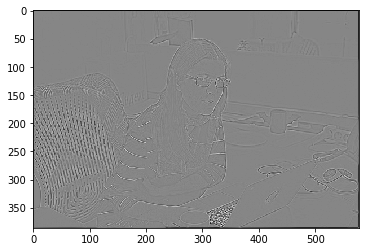

In [3]:
import scipy.signal as ss
B = np.array([[-1, -1, -1],
              [-1,  8, -1],
              [-1, -1, -1]])


conf = ss.convolve(img, B)
imgplot = plt.imshow(conf, cmap='Greys_r')

**Этот фильтр - дискретное приближение лапласиана его часто применяют в задачах выделения границ или выделения движения. Тут похоже на выделение границ.**

#### № 1

**B будет сепарабельной сверткой. Рассмотрим светку C**
$$С = \begin{pmatrix}
3 & 6 & 9\\
4 & 8 & 12\\
5 & 10 & 15
\end{pmatrix}$$
**Она будет тоже сепарабельной:**
$$A * C = (A * U) * V$$

$$U = \begin{pmatrix}
3\\
4\\
5
\end{pmatrix}, V = \begin{pmatrix}
1 &2 & 3\end{pmatrix}
$$
**Проверим ассоцитивность операции**


Text(0.5,1,'A*(B*C)')

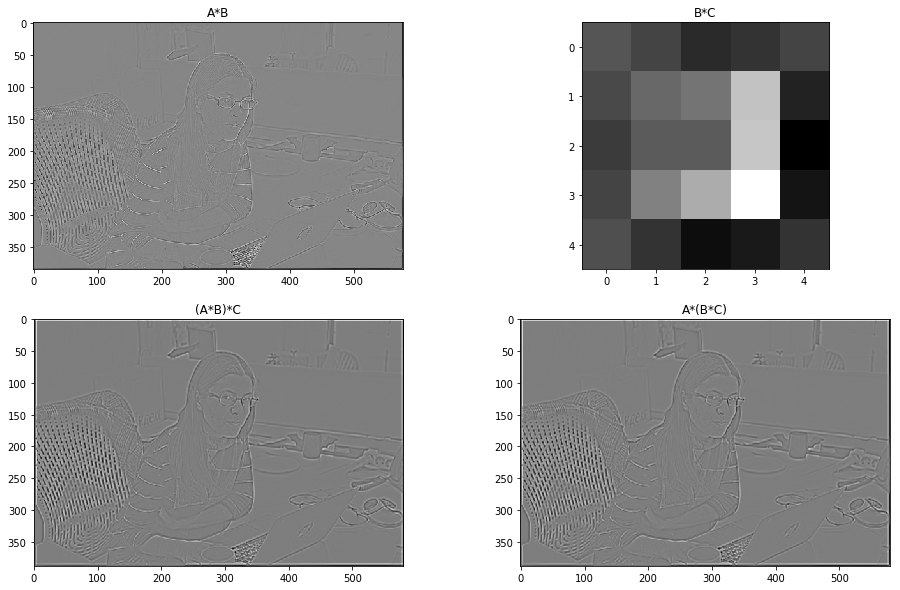

In [11]:
C = np.array([[3, 6, 9],
              [4, 8, 12],
              [5, 10, 15]])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

AB = ss.convolve2d(img, B)
axes[0][0].imshow(AB, cmap='Greys_r')
axes[0][0].set_title("A*B")
ABC1 = ss.convolve2d(AB, C)
axes[1][0].imshow(ABC1, cmap='Greys_r')
axes[1][0].set_title("(A*B)*C")

BC = ss.convolve2d(B, C)
axes[0][1].imshow(BC, cmap='Greys_r')
axes[0][1].set_title("B*C")
ABC2 = ss.convolve2d(img, BC)
axes[1][1].imshow(ABC1, cmap='Greys_r')
axes[1][1].set_title("A*(B*C)")
plt.show()

In [197]:
print("(A*B)*C == A*(B*C) ? {}".format(all(ABC1 == ABC2)))

(A*B)*C == A*(B*C) ? True


**Видно, что сепарабильная свертка действительно ассоциативна**

#### № 2

**Убедимся, что сепарабельная свертка действительно быстрее.**

In [204]:
default_times = []
separ_times = []

dims = np.arange(3, 30, dtype=int)

for dim in dims:
    u, v, B = np.random.randn(dim, 1), np.random.randn(1, dim), np.random.randn(dim, dim)
    
    t1 =  timeit.default_timer()
    ss.convolve2d(ss.convolve2d(img, u), v)
    t2 =  timeit.default_timer()
    separ_times.append((t2 - t1)*1000)
    
    t1 =  timeit.default_timer()
    time = ss.convolve2d(img, B)
    t2 =  timeit.default_timer()
    default_times.append((t2 - t1)*1000)

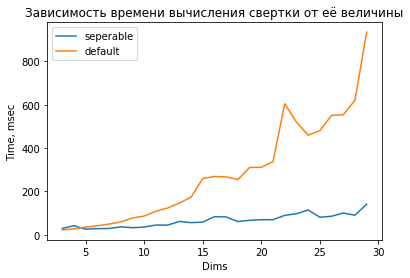

In [205]:
plt.plot(dims, separ_times, label = "seperable")
plt.plot(dims, default_times, label = "default")
plt.title("Зависимость времени вычисления свертки от её величины")
plt.xlabel("Dims")
plt.ylabel('Time, msec')
plt.legend()
plt.show()

**Видно, что сепарабельная свертка работает гораздно бысрее и с ростом размерности свертки время стремительно отличается. Это действительно так, потому что нужно проделать меньше операций. В этом случае нужно для каждого элемента исходной матрицы сделать $m$ умножений и сложить $m$ чисел (не учитывая граничные условия), т.е. для матрицы размера $NxN$ понадобится $N^2m$ умножений и $N²(m-1)$ сложений, и это нужно проделать для вертикального и горизонтального вектора, то есть всего операций будет $4N^2 m - 2N^2$. Для свёртки с квадратным фильтром понадобится $N^2m^2$ умножений и $N^2(m^2 - 1)$ сложений.**

#### № 3

**Будем использовать только первую главную компоненту в SVD разложения матричной свертки B, поскольку у получившихся $U$ и $V$ размерности должны быть единичными.**

**Предполагается, что несепарабельная свертка в это имеет лучше качество, чем сепарабельная. Тогда ошибку будем оценивать из отношения нормы сепарабельной свертки к обычной и из отклонения сепарабельной свертки относительно обычной.**

Отношение нормы сепарабельной свертки к обычной  1.1087762342744993
Отклонение сепарабельной свертки относительно обычной  0.1185270494410249


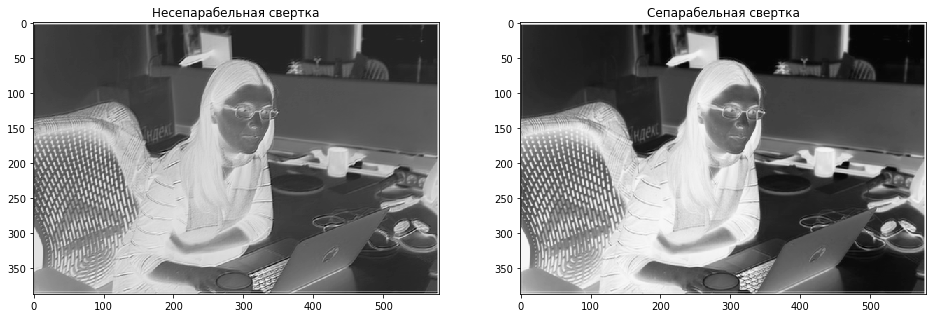

In [211]:
B = np.random.randn(5, 5)
U, S, V = sp.linalg.svd(B, full_matrices=False)
u, v = U[:,0:1] * S[0:1], V[0:1,:]
conv_sep = ss.convolve2d(ss.convolve2d(img, u), v)
conv_usual = ss.convolve2d(img, B)
fig, axes = plt.subplots(ncols=2, figsize=(16, 10))
axes[0].imshow(conv_usual, cmap='Greys_r')
axes[0].set_title("Несепарабельная свертка")
axes[1].imshow(conv_sep, cmap='Greys_r')
axes[1].set_title("Сепарабельная свертка")

print("Отношение нормы сепарабельной свертки к обычной ", sp.linalg.norm(conv_sep) / sp.linalg.norm(conv_usual))
print("Отклонение сепарабельной свертки относительно обычной ",sp.linalg.norm(conv_usual - conv_sep) / sp.linalg.norm(conv_usual))
plt.show()

**Мы получили действительно похожие изображения. Причем отношение нормы сепарабельной свертки к обычной близко к единице, а отклонение сепарабельной свертки относительно обычной близко к нулю. Ошибка в данном случае около 10%. **

#### № 4

**Вспомним, что если $B$ -- строка, то не происходит суммирования по $p$ (см. определение):
$$
    (A * B)_{ij} = \sum_{q = -s}^s a_{i, j + q} b_{1, q + s + 1},
$$
то есть тут мы свернули $i$-ю строку матрицы $A$, начиная с $(j - s)$-го элемента, с $B$.**

**Теперь распишем общее определение:
$$
    (A * B)_{ij} = \sum_{p = -t}^t\sum_{q = -s}^sa_{i + p,j + q} b_{p + t + 1,q + s + 1} = 
    \sum_{p = -t}^t \left[ \sum_{q = -s}^s a_{i + p, j + q} b_{p + t + 1,q + s + 1}\right] =^*
    \sum_{p = -t}^t (A_{(i + p)} * B_{(p + t + 1)})_{1, j}
$$
В переходе $*$ нужно заметить, глядя на вехнюю формулу, что это на самом деле свёртка $(i+p)$-й строки матрицы $A$ и $(p + t + 1)$-ой строки матрицы $B$. Индекс $(1, j)$ получился из-за того, что в $A_{(i + p)}$ ровно одна строка (она сама).**

## 5. Линейная Алгебра и Машинное Обучение   (до 6 баллов)

Хорошее знание линейной алгебры очень важно в современном машинном обучении. В этом задании Вам предлагается реализовать метод машинного обучения применив знания матричного дифференцирования и итерационных методов решения систем уравнений :) 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов, $+1$ или $-1$ для каждого объекта) является логистическая регрессия. Она выводится из метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{C}{2} ||w||^2 \longrightarrow \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

Здесь $X$ - матрица объекты-признаки для обучающей выборки (по строкам объекты, по столбцам признаки), а $y$ - вектор ответов. Коэффициент $C$, вообще говоря, нужно подбирать отдельно, поскольку разные его значения приводят к разным решениям задачи оптимизации. Но так как это уже никакого отношения не имеет к линейной алгебре, то в этой задаче мы положим $\mathbf{C = 1}$

Когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

План у нас такой:
- Вычислить градиент функции $L$, эффективно запрограммировать и проверить себя
- Вычислить гессиан функции $L$,  эффективно запрограммировать и проверить себя
- Воспользоваться методом второго порядка для оптимизации 
- Внутри метода оптимизации вместо обращения матрицы, решать систему уравнений с помощью итерационного метода
- Исследовать эффективность различных методов решения системы уравнений на реальных данных

Для тестирования правильности вычисления сгенерируем аргументы небольшого размера

In [92]:
w, X, y = np.random.random(10), np.random.random((11, 10)), 2*(np.random.randint(0, 2, 11)-0.5)

In [93]:
print(y)

[-1.  1.  1. -1. -1.  1.  1.  1. -1. -1. -1.]


**Задача 5.0 (0,5 балла)**

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(-(·)))`.

In [94]:
def logistic(w, X, y):
    '''
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (N,)
        
        funcw: np.float 
    '''
    
    yXw = np.multiply(y, X.dot(w))
    funcw = (np.logaddexp(0, -(yXw))).sum() + 0.5*w.T.dot(w)
    return funcw

**Сверим навсякий случай с реализацией sklearn**

In [95]:
from sklearn.linear_model import logistic as log_sk
print("my logistic\n", logistic(w, X, y))
print("sklearn logistic\n", log_sk._logistic_loss(w, X, y, 1))

my logistic
 18.430683362808303
sklearn logistic
 18.430683362808303


**Огонь!**

**Задача 5.1 (1 балл)**

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций

$$expit(x) = \frac{1}{1+exp(-x)}$$

$$\nabla_w L(w, X, y) = \sum_{i} \left(\frac{1}{1 + exp(y_ix_i^Tw)} (-y_ix_i)\right) + Cw = - X^{T}\left(\frac{1}{1 + exp(y \cdot Xw)}\right)\cdot y + Cw = - X^{T}\left(expit(y\cdot Xw)\right)\cdot y + Cw = X^{T}\left(expit(y\cdot Xw) - 1\right)\cdot y + Cw
$$ 



Эффективно запрограммируйте вычисление градиента (опять же, только матричные операции!)

Обратите внимание на то, что для разреженных матриц понадобится написать немного другой код.

In [96]:
def logistic_grad(w, X, y):
    '''
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    '''
    if sps.issparse(X):
        yXw = y * (X @ w)
        sigma = sp.special.expit(yXw)
        gradw = (X.T)@((sigma - 1)*y) + w
    else:
        yXw = np.multiply(y, X.dot(w))
        sigma = sp.special.expit(yXw)
        gradw = (X.T).dot((sigma - 1)*y) + w
    return gradw

In [97]:
assert(logistic_grad(w, X, y).shape == w.shape)

**Проверим также с sklearn:**

In [98]:
grad = logistic_grad(w, X, y)
print("my grad\n", grad)
grad, hess  = log_sk._logistic_grad_hess(w, X, y, 1)
print("sklearn grad\n", grad)

my grad
 [3.45795863 2.12292051 2.18633233 3.08237428 3.79408439 3.71015109
 3.9116919  2.28377142 3.40143417 2.23447281]
sklearn grad
 [3.45795863 2.12292051 2.18633233 3.08237428 3.79408439 3.71015109
 3.9116919  2.28377142 3.40143417 2.23447281]


Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью конечных разностей. 

$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

Ваша функция должна корректно работать хотя бы с обыкновенными (не разреженными матрицами)

In [99]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, w, eps=1e-8):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.float64), func(w), np.zeros_like(w)
    for i in range(w.size):
        ei = np.zeros(w.size)
        ei[i] = 1
        dnum[i] = (func(w + eps * ei) - fval) / eps
    return dnum

In [100]:
mat_grad = logistic_grad(w, X, y)
num_grad = grad_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

err =  3.8197143137352896e-07 ok


**Задача 5.2 (1 балл)**

Для некоторых задач оптимизации очень удобно использовать гессиан. 

Вычислите гессиан для функции L, запишите ответ в терминах матричных операций. 

**Упражнение**: Можно ли что-то сказать про знакоопределенность этой матрицы?

$$\nabla_w^2 L(w, X, y) = \frac{d}{dw}\left(X^{T}\left(expit(y\cdot Xw) - 1\right)\cdot y + Cw\right) = (y \cdot X)^T  A (y\cdot X) + CE$$

**где,** 

$$A_{ii} = \left( expit(y_i\cdot X_i^{T}w))(1 - expit(y_i\cdot X_i^{T}w)\right)
$$


**По определению матрица A получилась положительно опредлена, значит и матрица Гессе тоже положительно определена. Из этого следует что функция является выпуклой и локальный минимум - глобальный. **

Эффективно запрограммируйте вычисление гессиана. Не забудьте написать отдельную рутину для разреженных матриц.

In [101]:
def logistic_hess(w, X, y):
    '''
        logistic_hess(w, X, y) вычисляет гессиан функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        hessw: np.array размера (M, M)
    '''
    N, M = X.shape
    if sps.issparse(X):
        yXw = y * (X @ w)
        sigma = sp.special.expit(yXw)
        A = sps.diags(sigma*(1 - sigma))
        yX = y.reshape(N,1) * (X.toarray())
        hessw = yX.T @ A @ yX + np.eye(M)
        
    else:
        yXw = np.multiply(y, X.dot(w))
        sigma = sp.special.expit(yXw)
        A = np.diag(sigma*(1 - sigma))
        yX = np.multiply(y.reshape(N,1), X)
        hessw = (yX).T.dot(A).dot(yX) + np.eye(M)
    
    return hessw

In [102]:
assert(logistic_hess(w, X, y).shape == (w.shape[0], w.shape[0]))

Теперь проверим правильность реализации подсчёта гессиана

Для гессиана проверка выглядит похожим образом

$$[\nabla^2 f(x)]_{ij} \approx \frac{f(x + \epsilon \cdot e_i + \epsilon \cdot e_j) -f(x + \epsilon \cdot e_i) - f(x + \epsilon \cdot e_j)+ f(x)}{\epsilon^2}~~~~~~~~~~~~~~~~~~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-5}$

In [104]:
def hess_finite_diff(func, w, eps=1e-5):
    '''
        w: np.array размера (M,)
        func: скалярная функция от векторного аргумента w, func(w) =  число
        eps: np.float константа для проверки градиента
        
        dnum: np.array размера (M,), численно посчитанный градиент
    '''
    w, fval, dnum = w.astype(np.longdouble), func(w).astype(np.longdouble), np.zeros((w.size, w.size), dtype=np.longdouble)
    for i in range(w.size):
        ei = np.zeros(w.size)
        ei[i] = 1
        for j in range(w.size):
            ej = np.zeros(w.shape)
            ej[j] = 1
            dnum[i, j] = ((func(w + eps * ei + eps * ej) - func(w + eps * ei) - func(w + eps * ej) + fval)) / (eps ** 2)
    return dnum

In [106]:
mat_grad = logistic_hess(w, X, y)
num_grad = hess_finite_diff(lambda w: logistic(w, X, y), w)

err = max_error(mat_grad, num_grad)

print('err = ', err)
print('ok' if max_error(mat_grad, num_grad) < 1e-4 else 'ошибка оч большая =(') 

err =  9.215898375905529e-05
ok


**Задача 5.3 (3+ баллов)**

Так как наша задача оптимизации оказывается выпуклой (см. упражнение про знакоопределённость Гессиана), её можно эффективно решать методом второго порядка, например, методом Ньютона. Напомним, что в общем виде метод Ньютона для решения уравнения (системы уравнений) $H(z) = 0$ имеет вид

$$z_{k+1} = w_k - \mathbf{\alpha_k}\left(\nabla H(z_k)\right)^{-1}H(z_k)$$

Множитель $a_k$ не вполне каноничен, но его введение может ускорять сходимость.

Решение задачи оптимизации $f(w) \rightarrow \min\limits_w$ сводится к нахождению нулей градиента $\nabla f(w) = 0$. Получаем следующий итеративный процесс:

$$w_{k + 1} = w_k - \alpha_k\left(\nabla^2 f(x_k)\right)^{-1} \cdot \nabla f(x_k) =: w_k - \alpha_k d_k$$

Иными словами, основная идея метода Ньютона -- на шаге $k$ выбрать направление спуска $d_k$ с помощью градиента и гессиана, определить длину шага $\alpha_k$ по направлению $d_k$, и повторять сей процесс до сходимости (в выпуклой задаче можно считать, что это 20 итераций).

В методе Ньютона каждое следующее направление оптимизации выбирается как 

$$d_{k+1} = -(\nabla^2 f(x_k))^{-1} \cdot \nabla f(x_k)$$

но, вот беда, операция поиска обратной матрицы очень дорогая и не устойчивая, поэтому будем искать $d_{k+1}$ как решение системы уравнений

$$\nabla^2 f(x_k) d_{k+1} = -\nabla f(x_k)$$

Первым делом вам нужно будет реализовать метод Ньютона.

*Замечание*: Если вы хорошо реализовали вычисление градиента и гессиана, то в функции `newton` вам не понадобилось отдельно обрабатывать разреженные матрицы.

In [107]:
from scipy.optimize.linesearch import line_search_armijo

def newton(func, grad, hess, w0, solver, max_iter=20):
    '''
        func: скалярная функция от вектора размера shape(w0)
        grad: функция вычисляющая градиент функции func
        hess: функция вычисляющая гессиан  функции func
        
        w0: вектор, первая точка в процессе оптимизации 
        solver: функция от двух аргументов A, b находит решение системы Ax=b
        max_iter: количество итераций метода
    '''
    
    x, fvals, ngrads = w0.copy().astype(np.float), [], []
        
    for iter in range(max_iter):
        fvalx, gradx, hessx = func(x), grad(x), hess(x)
        d = solver(hessx, -gradx)
        alpha = line_search_armijo(func, x, d, gradx, fvalx)
        x += alpha[0] * d
        fvals.append(fvalx)
        ngrads.append(np.linalg.norm(gradx))

    return x, fvals, ngrads

In [108]:
# Пример запуска

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)
gauss_  = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
lgmres_  = lambda A, b: spla.lgmres(A, b, tol=1e-2)[0]
cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]

%time w_opt, fvals, ngrads = newton(func, grad, hess, w, cg_) 

Wall time: 31.5 ms


В этом задании вам необходимо в зависимости от метода решения системы уравнений (гаусс, CG, GMRES) исследовать:
- зависимость времени работы метода оптимизации от выбора метода решения системы;
- скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`);
- какую часть времени метод тратит на решение системы уравнений и какую на вычисление гессиана и градиента.

Эксперименты нужно провести на нескольких наборах данных. Рассмотрите следующие три ситуации: 
- малое число признаков d < 100
- среднее число признаков d ~ 500 
- большое число признаков d ~ 1000

Мы будем поощрять любые дополнительные исследования, например, если вы попытаетесь проверить статистическую значимость результатов экспериментов: ведь если какой-нибудь метод показал себя лучше в одном-единственном эксперименте, то это ещё ничего не значит.

**Рекомендация**: можете рассмотреть три набора данных, которые можно скачать с сайта [LIBSVM1](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html): **a9a**, **w8a** (много объектов, сравнительно немного признаков) и **colon-cancer** (в нём достаточно мало объектов, но зато гораздо больше признаков).

Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в формате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию [load_svmlight_file](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html) из модуля sklearn.datasets. Эта функция всегда возвращает матрицу X типа sp.sparse.csr_matrix (разреженная марица). В датасете **colon-cancer** матрица X не будет разреженной, поэтому сразу же после вызова функции load_svmlight_file следует привести X к типу np.ndarray. Это можно сделать с помощью команды X = X.toarray().

**Загрузка данных**

In [109]:
from sklearn import datasets
X_a9a, y_a9a  = datasets.load_svmlight_file("a9a.txt")
X_w8a, y_w8a  = datasets.load_svmlight_file("w8a.txt")
X_colon_cancer, y_colon_cancer = datasets.load_svmlight_file("colon-cancer.bz2")
X_colon_cancer = X_colon_cancer.toarray()
#X_a9a = X_a9a.toarray()
#X_w8a = X_w8a.toarray()
data = {"a9a": (X_a9a, y_a9a),"w8a": (X_w8a, y_w8a), "colon_cancer" : (X_colon_cancer, y_colon_cancer)}

**Функция для статистической устойчивости по времени среднее между $1$-ым и $3$-им уровнем кватилей для исключение выбросов**

In [110]:
import timeit

In [111]:
def box_filter(timing, left=0.25, right=0.75):
    timing.sort()
    size = len(timing)
    if size == 1:
        return timing[0]

    Q1, Q2 = timing[int(size * left)], timing[int(size * right)]

    IQ = Q2 - Q1

    lower = Q1 - 1.5 * IQ
    upper = Q2 + 1.5 * IQ

    result = np.array([item for item in timing if lower < item < upper])
    return np.mean(result)

**Зависимость времени работы метода оптимизации от выбора метода решения системы**

In [54]:
cfg = {}

NREPEAT = 5

for key, value in data.items():
    X, y = value
    func = lambda w: logistic(w, X, y)
    grad = lambda w: logistic_grad(w, X, y)
    hess = lambda w: logistic_hess(w, X, y)
    gauss_ = lambda A, b: spla.spsolve(A, b) if sps.issparse(A) else sla.solve(A, b)
    lgmres_ = lambda A, b: spla.lgmres(A, b, atol=1e-2)[0]
    cg_  = lambda A, b: spla.cg(A, b, tol=1e-2)[0]
    print(X.shape)
    w = np.random.rand(X.shape[1])
    
    def gauss_method():
        global w_opt, fvals_gauss, ngrads
        w_opt, fvals_gauss, ngrads = newton(func, grad, hess, w, gauss_)

    t = timeit.Timer(stmt="%s()" % gauss_method.__name__, setup="from __main__ import %s" % gauss_method.__name__)
    res_t = t.repeat(repeat=NREPEAT, number=1)
    stat_time = 1000.0 * box_filter(res_t)
    cfg[key] = {'gauss': (fvals_gauss, stat_time)}
    
    def lgmres_method():
        global w_opt, fvals_gauss, ngrads
        w_opt, fvals_gauss, ngrads = newton(func, grad, hess, w, lgmres_)

    t = timeit.Timer(stmt="%s()" % lgmres_method.__name__, setup="from __main__ import %s" % lgmres_method.__name__)
    res_t = t.repeat(repeat=NREPEAT, number=1)
    stat_time = 1000.0 * box_filter(res_t)
    cfg[key].update({'lgmres': (fvals_gauss, stat_time)})
    
    def cg_method():
        global w_opt, fvals_gauss, ngrads
        w_opt, fvals_gauss, ngrads = newton(func, grad, hess, w, cg_)

    t = timeit.Timer(stmt="%s()" % cg_method.__name__, setup="from __main__ import %s" % cg_method.__name__)
    res_t = t.repeat(repeat=NREPEAT, number=1)
    stat_time = 1000.0 * box_filter(res_t)
    cfg[key].update({'cg': (fvals_gauss, stat_time)})


(32561, 123)
(49749, 300)
(62, 2000)


In [56]:
for key, value in cfg.items():
    print(key)
    print("Data : {}; Dataset ({} x {})".format(key, data[key][0].shape[0], data[key][0].shape[1]))
    fval, time = value['gauss']
    print("Gauss time - {} ms".format(time))
    
    fval, time = value['lgmres']
    iterations = np.arange(len(fval))
    print("lgmres time - {} ms".format(time))
        
    fval, time = value['cg']
    iterations = np.arange(len(fval))
    print("cg time - {} ms".format(time))
    print()

a9a
Data : a9a; Dataset (32561 x 123)
Gauss time - 3871.077202222139 ms
lgmres time - 4098.597130536874 ms
cg time - 4331.327449108784 ms

w8a
Data : w8a; Dataset (49749 x 300)
Gauss time - 16776.58198220631 ms
lgmres time - 14362.682163963058 ms
cg time - 15003.992579790236 ms

colon_cancer
Data : colon_cancer; Dataset (62 x 2000)
Gauss time - 8679.236576975312 ms
lgmres time - 4430.976832148758 ms
cg time - 3535.4095462239175 ms



**Видно, что при больших количествах признаков метод Гаусса справляется хуже остальных. Давайте посмотрим на сходимость этих методов:**

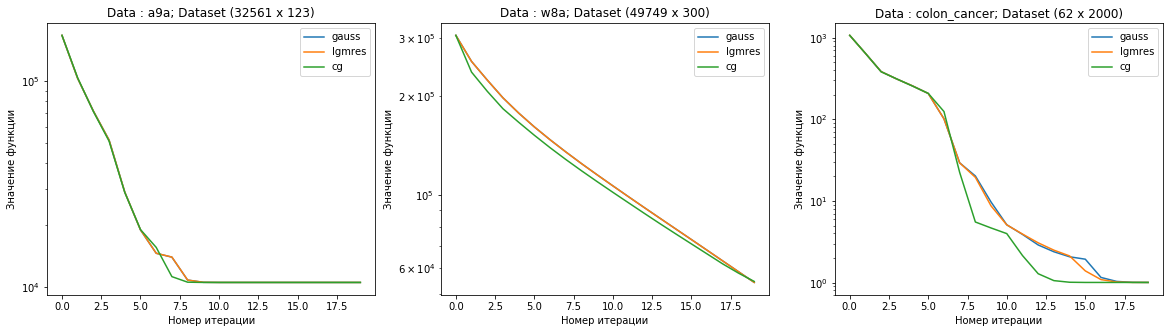

In [57]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
for i, (key, value) in enumerate(cfg.items()):
    fval, time = cfg[key]['gauss']
    iterations = np.arange(len(fval))
    axes[i].plot(iterations, fval, label = "gauss")
    
    fval, time = cfg[key]['lgmres']
    iterations = np.arange(len(fval))
    axes[i].plot(iterations, fval, label = "lgmres")
        
    fval, time = cfg[key]['cg']
    iterations = np.arange(len(fval))
    axes[i].plot(iterations, fval, label = "cg")
        
    axes[i].set_title("Data : {}; Dataset ({} x {})".format(key, data[key][0].shape[0], data[key][0].shape[1]))
    axes[i].set_xlabel("Номер итерации")
    axes[i].set_ylabel("Значение функции")
    axes[i].set_yscale('log')
    axes[i].legend()
    

**Метод Гаусса и lgmres почти сходятся с одинковой скоростью. Но метод cg сходится во всех случаяхх немного быстрее. Что стоит конечно учитывать при выборе метода. Метода Гаусса использует стандартный алгоритм решения СЛАУ и ищет точное решение, в то время как другие 2 метода являются итеративными и ищут только приближенное решение. В итоге при почти одинковой по времени работе методов cg и lgmress, предпочтения отдадим cg за счет того, что сходится он быстрее.**

**Скорость сходимости метода оптимизации в зависимости от точности решения системы уравнений (параметр `tol`)**

**Будет сравнивать методы cg и lgmres**

In [70]:
NREPEAT = 5

cfg_lgmres = {}
cfg_cg = {}

tolerance = np.array([1e-10, 1e-8, 1e-6, 1e-4, 1e-2])
times_lgmres = {}
times_cg = {}

for key, value in data.items():
    X, y = value
    func = lambda w: logistic(w, X, y)
    grad = lambda w: logistic_grad(w, X, y)
    hess = lambda w: logistic_hess(w, X, y)
    cfg_lgmres[key] = {}
    cfg_cg[key] = {}
    
    times_lgmres[key] = []
    times_cg[key] = []
    for tol in tolerance:

        lgmres_ = lambda A, b: spla.lgmres(A, b, atol=tol)[0]
        cg_  = lambda A, b: spla.cg(A, b, tol=tol)[0]
        print(tol, X.shape)
        w = np.random.rand(X.shape[1])

        def lgmres_method():
            global w_opt, fvals_gauss, ngrads
            w_opt, fvals_gauss, ngrads = newton(func, grad, hess, w, lgmres_)

        t = timeit.Timer(stmt="%s()" % lgmres_method.__name__, setup="from __main__ import %s" % lgmres_method.__name__)
        res_t = t.repeat(repeat=NREPEAT, number=1)
        stat_time = 1000.0 * box_filter(res_t)
        times_lgmres[key].append(stat_time)
        cfg_lgmres[key].update({ tol : (fvals_gauss, stat_time)})

        def cg_method():
            global w_opt, fvals_gauss, ngrads
            w_opt, fvals_gauss, ngrads = newton(func, grad, hess, w, cg_)

        t = timeit.Timer(stmt="%s()" % cg_method.__name__, setup="from __main__ import %s" % cg_method.__name__)
        res_t = t.repeat(repeat=NREPEAT, number=1)
        stat_time = 1000.0 * box_filter(res_t)
        times_cg[key].append(stat_time)
        cfg_cg[key].update({ tol : (fvals_gauss, stat_time)})


1e-10 (32561, 123)
1e-08 (32561, 123)
1e-06 (32561, 123)
0.0001 (32561, 123)
0.01 (32561, 123)
1e-10 (49749, 300)
1e-08 (49749, 300)
1e-06 (49749, 300)
0.0001 (49749, 300)
0.01 (49749, 300)
1e-10 (62, 2000)
1e-08 (62, 2000)
1e-06 (62, 2000)
0.0001 (62, 2000)
0.01 (62, 2000)


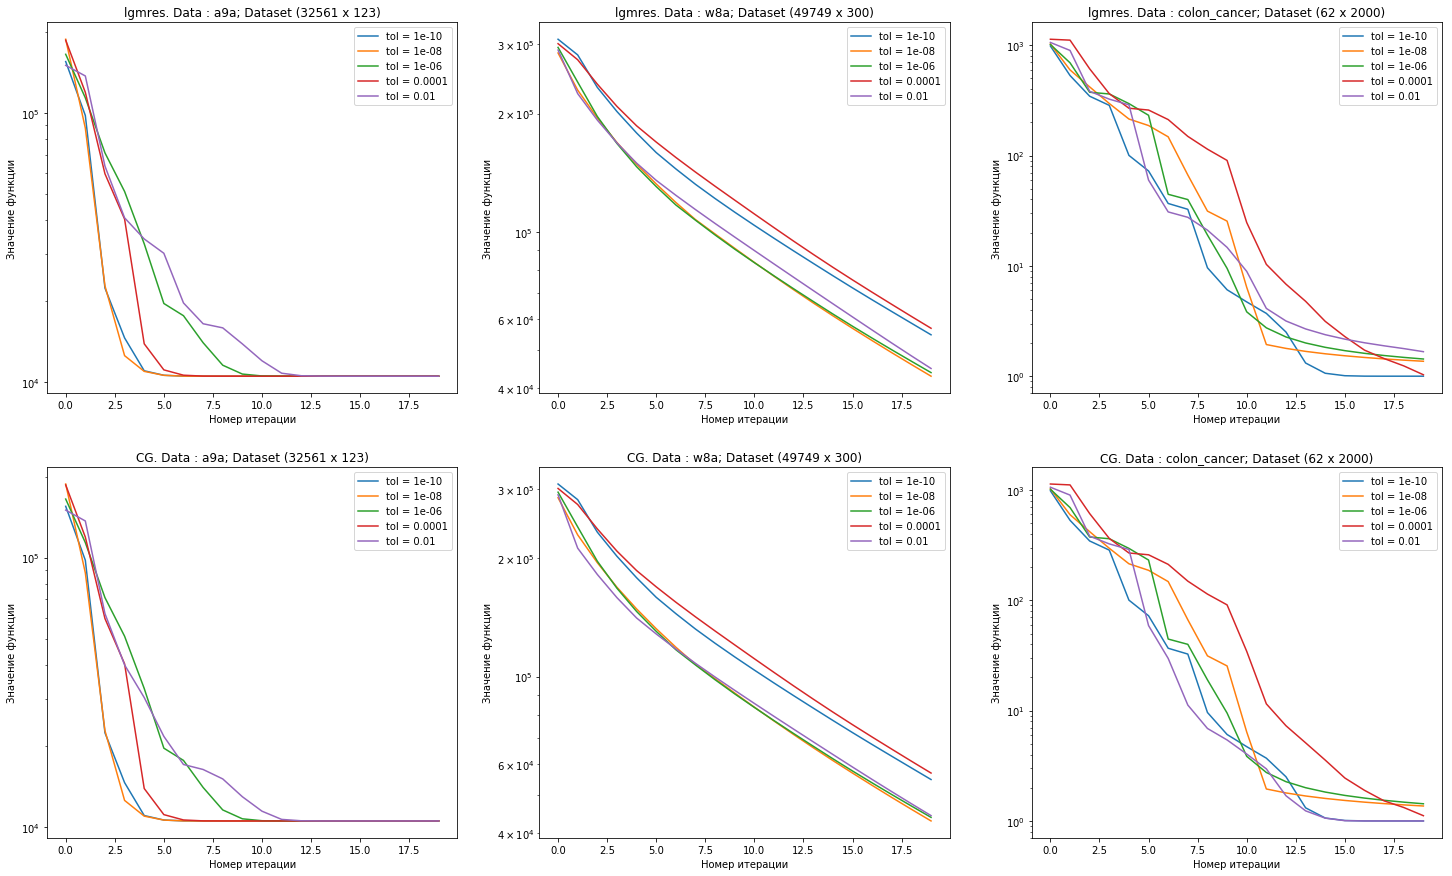

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 15))
for i, (key, value) in enumerate(cfg_lgmres.items()):
    for tol, val in value.items():
        fval, time = val
        iterations = np.arange(len(fval))
        axes[0][i].plot(iterations, fval, label = "tol = {}".format(tol))
        
    axes[0][i].set_title("lgmres. Data : {}; Dataset ({} x {})".format(key, data[key][0].shape[0], data[key][0].shape[1]))
    axes[0][i].set_xlabel("Номер итерации")
    axes[0][i].set_ylabel("Значение функции")
    axes[0][i].set_yscale('log')
    axes[0][i].legend()
    
for i, (key, value) in enumerate(cfg_cg.items()):
    for tol, val in value.items():
        fval, time = val
        iterations = np.arange(len(fval))
        axes[1][i].plot(iterations, fval, label = "tol = {}".format(tol))
        
    axes[1][i].set_title("CG. Data : {}; Dataset ({} x {})".format(key, data[key][0].shape[0], data[key][0].shape[1]))
    axes[1][i].set_xlabel("Номер итерации")
    axes[1][i].set_ylabel("Значение функции")
    axes[1][i].set_yscale('log')
    axes[1][i].legend()

plt.show()

**Методы lgmres и cg имеет схожие картинки сходимости. Но в зависимости от размерности траектории сходимости очень меняются. В целом видно, что не везде лучше сходтся метод с минимальной точностью, что вполне можно объяснить погрешностью вычислений. Даже интересно, что при большой погрещностью (0.1) есть размерность, гле он сходится быстрее остальных**

**Посмотрим на время выполнения в зависимости от точности итерационных методов**

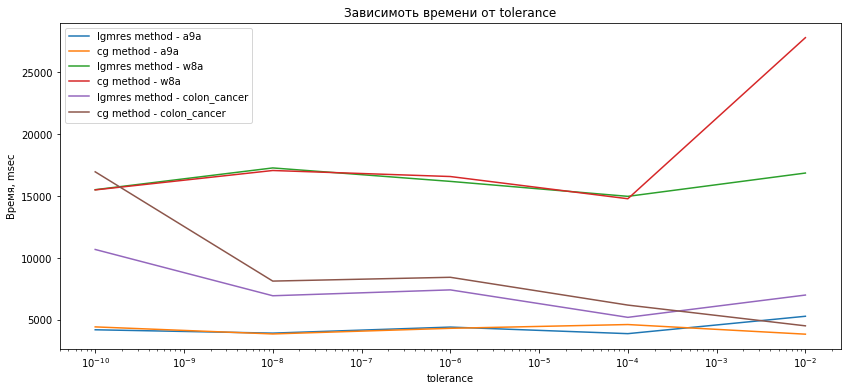

In [78]:
fig = plt.figure(figsize = (14,6))

for key, value in data.items():
    plt.plot(tolerance, times_lgmres[key], label = "lgmres method - {}".format(key))
    plt.plot(tolerance, times_cg[key], label = "cg method - {}".format(key))

plt.title("Зависимоть времени от tolerance")
plt.xlabel("tolerance")
plt.ylabel("Время, msec")
#     axes[i].set_yscale('log')
plt.xscale("log")
plt.legend()

plt.show()

**На датасете a9a не играет роль точность на время выполнния, это видимо связяно с тем, что у них меньше всех признаков. При увеличении количества признаков уменьшается время при уменьшении точности, что вообще то говоря, логично. Странно только ведет себя на датасете w8a, там время резко увеличивается на маленькой точности.**

**Сколько времени тратиться на конерктную часть - вычисление функции, вычисление градиента, вычисление гессиана**

In [114]:
def measure_gesse_grad_function(func, grad, hess, w, max_iter=20):

    time_func = []
    time_grad = []
    time_hess = []
        
    st = timeit.default_timer()
    fvalx = func(w)
    ft = timeit.default_timer()
    time_func = (ft-st)*1000
    st = timeit.default_timer()
    gradx = grad(w)
    ft = timeit.default_timer()
    time_grad = (ft-st)*1000
    st = timeit.default_timer()
    hessx = hess(w)
    ft = timeit.default_timer()
    time_hess = (ft-st)*1000
    return (time_func, time_grad, time_hess)

In [118]:
times = {}

for key, value in data.items():
    X, y = value
    func = lambda w: logistic(w, X, y)
    grad = lambda w: logistic_grad(w, X, y)
    hess = lambda w: logistic_hess(w, X, y)
    
    w = np.random.rand(X.shape[1])

    times[key] = measure_gesse_grad_function(func, grad, hess, w)

for key, value in times.items():
    print("FOR {}:\n function: {}; gradient {}; hesse {}".format(key, value[0], value[1], value[2]))

FOR a9a:
 function: 5.981060327030718; gradient 4.579842003295198; hesse 183.19680378772318
FOR w8a:
 function: 5.230471404502168; gradient 5.961871676845476; hesse 798.9117799152154
FOR colon_cancer:
 function: 0.29050736338831484; gradient 0.15618675388395786; hesse 110.65921076806262


**Очевидно, для всех размерностях колоссальное количество времени тратит метод на вычисление матрицы Гессиана. Значение функции и градиента почти одинакого стоит.**

**Задача 5.4 (0 балов, весь код написан за вас, но очень красивые картинки)** 

Давайте визуализируем наш метод, а то хочется глазами посмотреть. Просто запустите код:

In [61]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, hessf, X, y, n_iter=10):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w, d = np.zeros(X.shape[1]), np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx, hessx = func(w), grad(w), hess(w)
        d = spla.cg(hessx, -gradx)[0]
        alpha = line_search_armijo(func, w, d, gradx, fvalx)[0]
        w += alpha*d
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [62]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

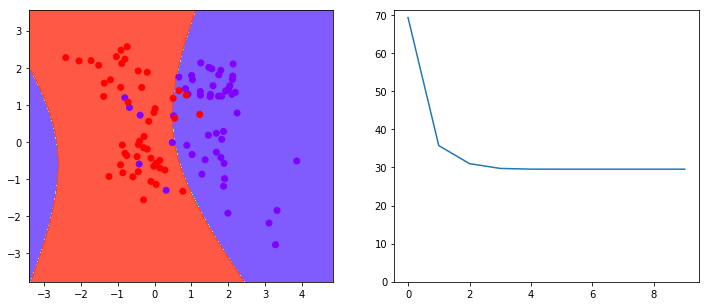

<Figure size 864x360 with 0 Axes>

In [65]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)
hess = lambda w: logistic_hess(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, hess, X, y) 

## 6. Blessing of dimensionality (3 балла)

В этом задании вы попробуете сжать временной ряд с помощью тензорных разложений.

Временной ряд - это вектор. Казалось бы, что с ним можно сделать? Оказывается, если он достаточно длинный, то можно попробовать много разных странных штук. Например, вы можете с помощью функции `reshape` преобразовать его в матрицу и эту матрицу сжать с помощью SVD (точно так же, как вы это делали с фотографией Сони). Или же преобразовать в тензор более высокой валентности и воспользоваться каким-нибудь тензорным разложением.

Загрузите временной ряд (если интересно, он взят [отсюда](https://www.quandl.com/data/BOE/XUDLNKG-Effective-Exchange-Rate-Index-Norwegian-Krone-1990-Average-100)) из файла `BOE-XUDLNKG.csv`

In [5]:
import pandas as pd

x = pd.read_csv(r'BOE-XUDLNKG.csv')['Value'].as_matrix()
x = x[:10332]

Сожмите его несколькими способами:
- с помощью SVD (трансформировав в матрицу, близкую к квадратной), 
- с помощью HOSVD (трансформировав в тензор валентности 3, по возможности близкий к кубическому) 
- с помощью тензорного поезда.

Постарайтесь не только минимизировать ранги, но и добиться, чтобы относительная ошибка --- то есть $\frac{||x - x'||}{||x||}$ --- в каждом случае была не больше 0,05.

Нарисуйте восстановленные из сжатых тензоров ряды. Во сколько раз в каждом из способов удаётся уменьшить объём хранимых данных?

*Замечание* В этом задании не надо пользоваться никакими специальными библиотеками, только стандартными функциями (например, `np.tensordot`, `np.transpose`, `reshape`, `sla.svd`).

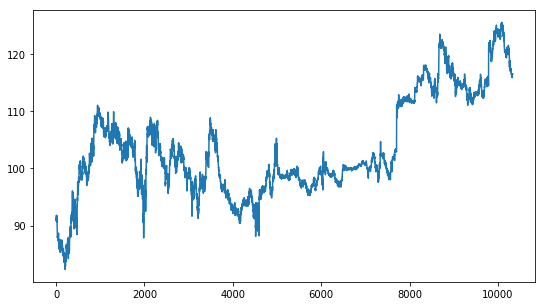

In [169]:
plt.plot(x)

$10332 = 2^2 \cdot 3^2 \cdot 7 \cdot 41$. Возьмём матрицу следующих размеров:

In [567]:
print(2 * 41, 2 * 3 * 7 * 3)
new_shape = (82, 126)
x_square = x.reshape(new_shape)

82 126


In [568]:
def GetFirstMComponents(x, m):
    U, D, V = sla.svd(x_square)
    components = np.zeros((U.shape[0], V.shape[0]))
    for k in range(m):
        components[k][k] = D[k]
    return (U.dot(components).dot(V)).reshape(components.shape[0] * components.shape[1])

In [569]:
def GetGoodPrecision(eps, x):
    for m in range(1, 82):
        delta = sla.norm(GetFirstMComponents(x, m) - x)/sla.norm(x)
        if delta < eps:
            return m, delta

In [570]:
GetGoodPrecision(0.05, x)

(1, 0.014871375557568723)

**Оказалось, что для достижения погрешности $0.05$ потребовалась всего одна компонента $SVD$-разложения. Посчитаем, сколько было сэкономлено памяти (по выведенной ранее формуле):**

$$
    \alpha = \frac{dim(U) \cdot dim(V)}{k (dim(U) + dim(U) + 1)} 
$$

In [572]:
U, D, V = sla.svd(x_square)
U.shape, V.shape

((82, 82), (126, 126))

$$
    \alpha = \frac{82 \cdot 126}{1 (82 + 126 + 1)} = 49
$$

**Мы можем использовать в 49 раз меньше памяти.
Нарисуем ряд, полученный с помощью SVD.**

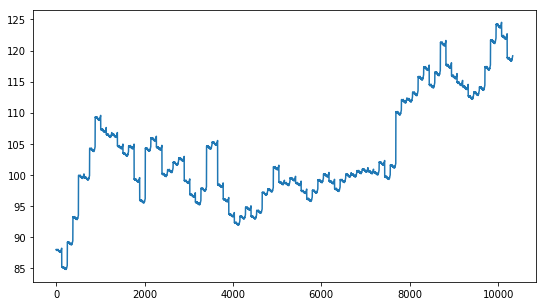

In [573]:
plt.plot(GetFirstMComponents(x, 1))

**Теперь HOSVD. Нам потребуется сделать кубик. Параллелепипед, максимально похожий на кубик**

In [574]:
(2 * 3 * 3, 2 * 7, 41)

(18, 14, 41)

In [583]:
def multiplyCubeMatrices(U, D, V):
    L = []
    for i in range(U.shape[0]):
        L.append(U[i].dot(D[i]).dot(V[i]))
    return np.array(L)

def GetFirstMComponents3D(U, D, V, m):
    components = np.zeros((U.shape[0], U.shape[1], V.shape[2]))
    for k in range(m):
        for horizontal in range (D.shape[0]):
            components[horizontal][k][k] = D[horizontal][k]   
    new_shape = components.shape[0] * components.shape[1] * components.shape[2]
    return multiplyCubeMatrices(U, components, V).reshape(new_shape)

In [579]:
def GetGoodPrecision3D(eps, x):
    x_cube = x.reshape(14, 18, 41)
    U, D, V = npla.svd(x_cube)
    
    for m in range (1, D.shape[0] + 1):
        D_m = GetFirstMComponents3D(U, D, V, m)
        delta = sla.norm(D_m - x)/sla.norm(x)
        if delta < eps:
            return (m, delta)

In [580]:
GetGoodPrecision3D(0.05, x)

(1, 0.008222297189894987)

In [582]:
x_cube = x.reshape(14, 18, 41)
U, D, V = npla.svd(x_cube)
print(D.shape[0])

14


**Хорошая точность достигается на первой компоненте (причём, третьего порядка). Память можно оценить, как будто мы для нескольких матриц (а именно для 14 - ровно столько "параллельных" SVD у нас вышло) посчитатали SVD и взяли только первую компоненту:**

$$
    \alpha = \frac{14 \cdot 18 \cdot 41}{14 \cdot 1 \cdot (18 + 41 + 1)} = 12
$$

**Память экономится примерно в 12 раз. Нарисуем полученный ряд.**

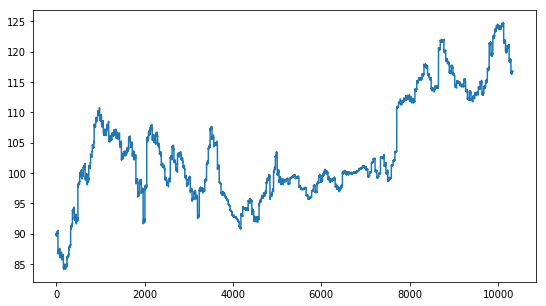

In [584]:
x_cube = x.reshape(14, 18, 41)
U, D, V = npla.svd(x_cube)
    
plt.plot(GetFirstMComponents3D(U, D, V, 1))